In [348]:
import pandas as pd

# ---ファイルの読み込むパスを指定---
file_path_left_foot = "/Users/lightswinner/Workspace/Research/WearableDevices/left_foot_data_imu.csv"
file_path_right_foot = "/Users/lightswinner/Workspace/Research/WearableDevices/right_foot_data_imu.csv"
file_path_motion_capture = "/Users/lightswinner/Workspace/Research/MotionCapture/Nagashio_test.csv"

# ---CSVファイルの読み込み---
df_left_foot = pd.read_csv(file_path_left_foot, header=0)
df_right_foot = pd.read_csv(file_path_right_foot, header=0)
df_motion_capture = pd.read_csv(file_path_motion_capture, header=6)

# --- モーションキャプチャデータのカラム名変更  ---
# 元のカラム名と新しいカラム名のマッピングを定義
rename_mapping = {
    # Left_Rotation: X, Y, Z, W
    'X': 'Left_Rotation_X',
    'Y': 'Left_Rotation_Y',
    'Z': 'Left_Rotation_Z',
    'W': 'Left_Rotation_W',

    # Left_Position: X.1, Y.1, Z.1
    'X.1': 'Left_Position_X',
    'Y.1': 'Left_Position_Y',
    'Z.1': 'Left_Position_Z',

    # Right_Rotation: X.2, Y.2, Z.2,
    'X.2': 'Right_Rotation_X',
    'Y.2': 'Right_Rotation_Y',
    'Z.2': 'Right_Rotation_Z',
    'W.1': 'Right_Rotation_W',

    # Right_Position: X.3, Y.3, Z.3, W.3
    'X.3': 'Right_Position_X',
    'Y.3': 'Right_Position_Y',
    'Z.3': 'Right_Position_Z',
}
# カラム名の変更を実行
df_motion_capture.rename(columns=rename_mapping, inplace=True)
df_motion_capture.columns


Index(['Frame', 'Time (Seconds)', 'Left_Rotation_X', 'Left_Rotation_Y',
       'Left_Rotation_Z', 'Left_Rotation_W', 'Left_Position_X',
       'Left_Position_Y', 'Left_Position_Z', 'Error', 'Right_Rotation_X',
       'Right_Rotation_Y', 'Right_Rotation_Z', 'Right_Rotation_W',
       'Right_Position_X', 'Right_Position_Y', 'Right_Position_Z', 'Error.1'],
      dtype='object')

In [349]:
import numpy as np
from scipy.interpolate import interp1d

# ---左右のデータ結合---
df_merged = pd.merge(df_left_foot, df_right_foot, on='ElapsedTime', how='outer')

# ---欠損地の補完---
exclude_cols = ['Marker_x', 'Marker_y']
existing_exclude_cols = [col for col in exclude_cols if col in df_merged.columns]
target_cols = df_merged.columns.difference(existing_exclude_cols)
df_merged[target_cols] = df_merged[target_cols].interpolate(method='linear', axis=0)

# ---時間軸を100Hzで再サンプリング---
# 時間軸の最小値と最大値を取得
time_min = 0
time_max = df_merged['ElapsedTime'].max()
# 10ms間隔で新しい時間軸を作成
sampling_interval = 10
# 新しい時間軸に基づいて補間を実行
new_time = np.arange(time_min, time_max, sampling_interval)
# 新しい時間軸で DataFrame 作成
df_interpolated = pd.DataFrame({'ElapsedTime': new_time})

df_markers = df_merged[['ElapsedTime', 'Marker_x', 'Marker_y']].dropna(subset=['Marker_x', 'Marker_y'], how='all').copy()
df_markers['ElapsedTime_rounded'] = (df_markers['ElapsedTime'] / sampling_interval).round() * sampling_interval
df_markers = df_markers.drop_duplicates(subset=['ElapsedTime_rounded'])
df_interpolated['MergeKey'] = df_interpolated['ElapsedTime'].round().astype(int)
df_markers['MergeKey'] = df_markers['ElapsedTime_rounded'].round().astype(int)
df_interpolated = pd.merge(
    df_interpolated,
    df_markers[['MergeKey', 'Marker_x', 'Marker_y']],
    left_on='MergeKey', # 整数キーで結合
    right_on='MergeKey',
    how='left'
)
df_interpolated = df_interpolated.drop(columns=['MergeKey'])

# 補間から除外するカラムのリスト
columns_to_exclude = ['ElapsedTime', 'Marker_x', 'Marker_y']
# ElapsedTime以外の各列に対して補間関数 (interp1d) を適用
for column in df_merged.columns:
    if column in columns_to_exclude:
        continue 
    # interp1d: 線形補間を行う関数を作成
    # kind='linear': 線形補間，fill_value='extrapolate': 範囲外は外挿
    interpolator = interp1d(df_merged['ElapsedTime'], df_merged[column], 
                            kind='linear', 
                            fill_value='extrapolate')
    # 新しい時間軸で値を計算
    df_interpolated[column] = interpolator(new_time)

# 単位の変換：ms (ミリ秒) を s (秒) に直すため 1000 で割る
df_interpolated['ElapsedTime'] = df_interpolated['ElapsedTime'] / 1000
# カラム名の変更：'ElapsedTime' を 'Time (Seconds)' に変更
df_interpolated = df_interpolated.rename(columns={'ElapsedTime': 'Time (Seconds)'})

# 結果の確認
print(df_interpolated.columns)



Index(['Time (Seconds)', 'Marker_x', 'Marker_y', 'Left_kPa_1', 'Left_kPa_2',
       'Left_kPa_3', 'Left_kPa_4', 'Left_kPa_5', 'Left_kPa_6', 'Left_kPa_7',
       'Left_kPa_8', 'Left_Accel_X', 'Left_Accel_Y', 'Left_Accel_Z',
       'Left_Gyro_X', 'Left_Gyro_Y', 'Left_Gyro_Z', 'Right_kPa_1',
       'Right_kPa_2', 'Right_kPa_3', 'Right_kPa_4', 'Right_kPa_5',
       'Right_kPa_6', 'Right_kPa_7', 'Right_kPa_8', 'Right_Accel_X',
       'Right_Accel_Y', 'Right_Accel_Z', 'Right_Gyro_X', 'Right_Gyro_Y',
       'Right_Gyro_Z'],
      dtype='object')


マーカー数: 3


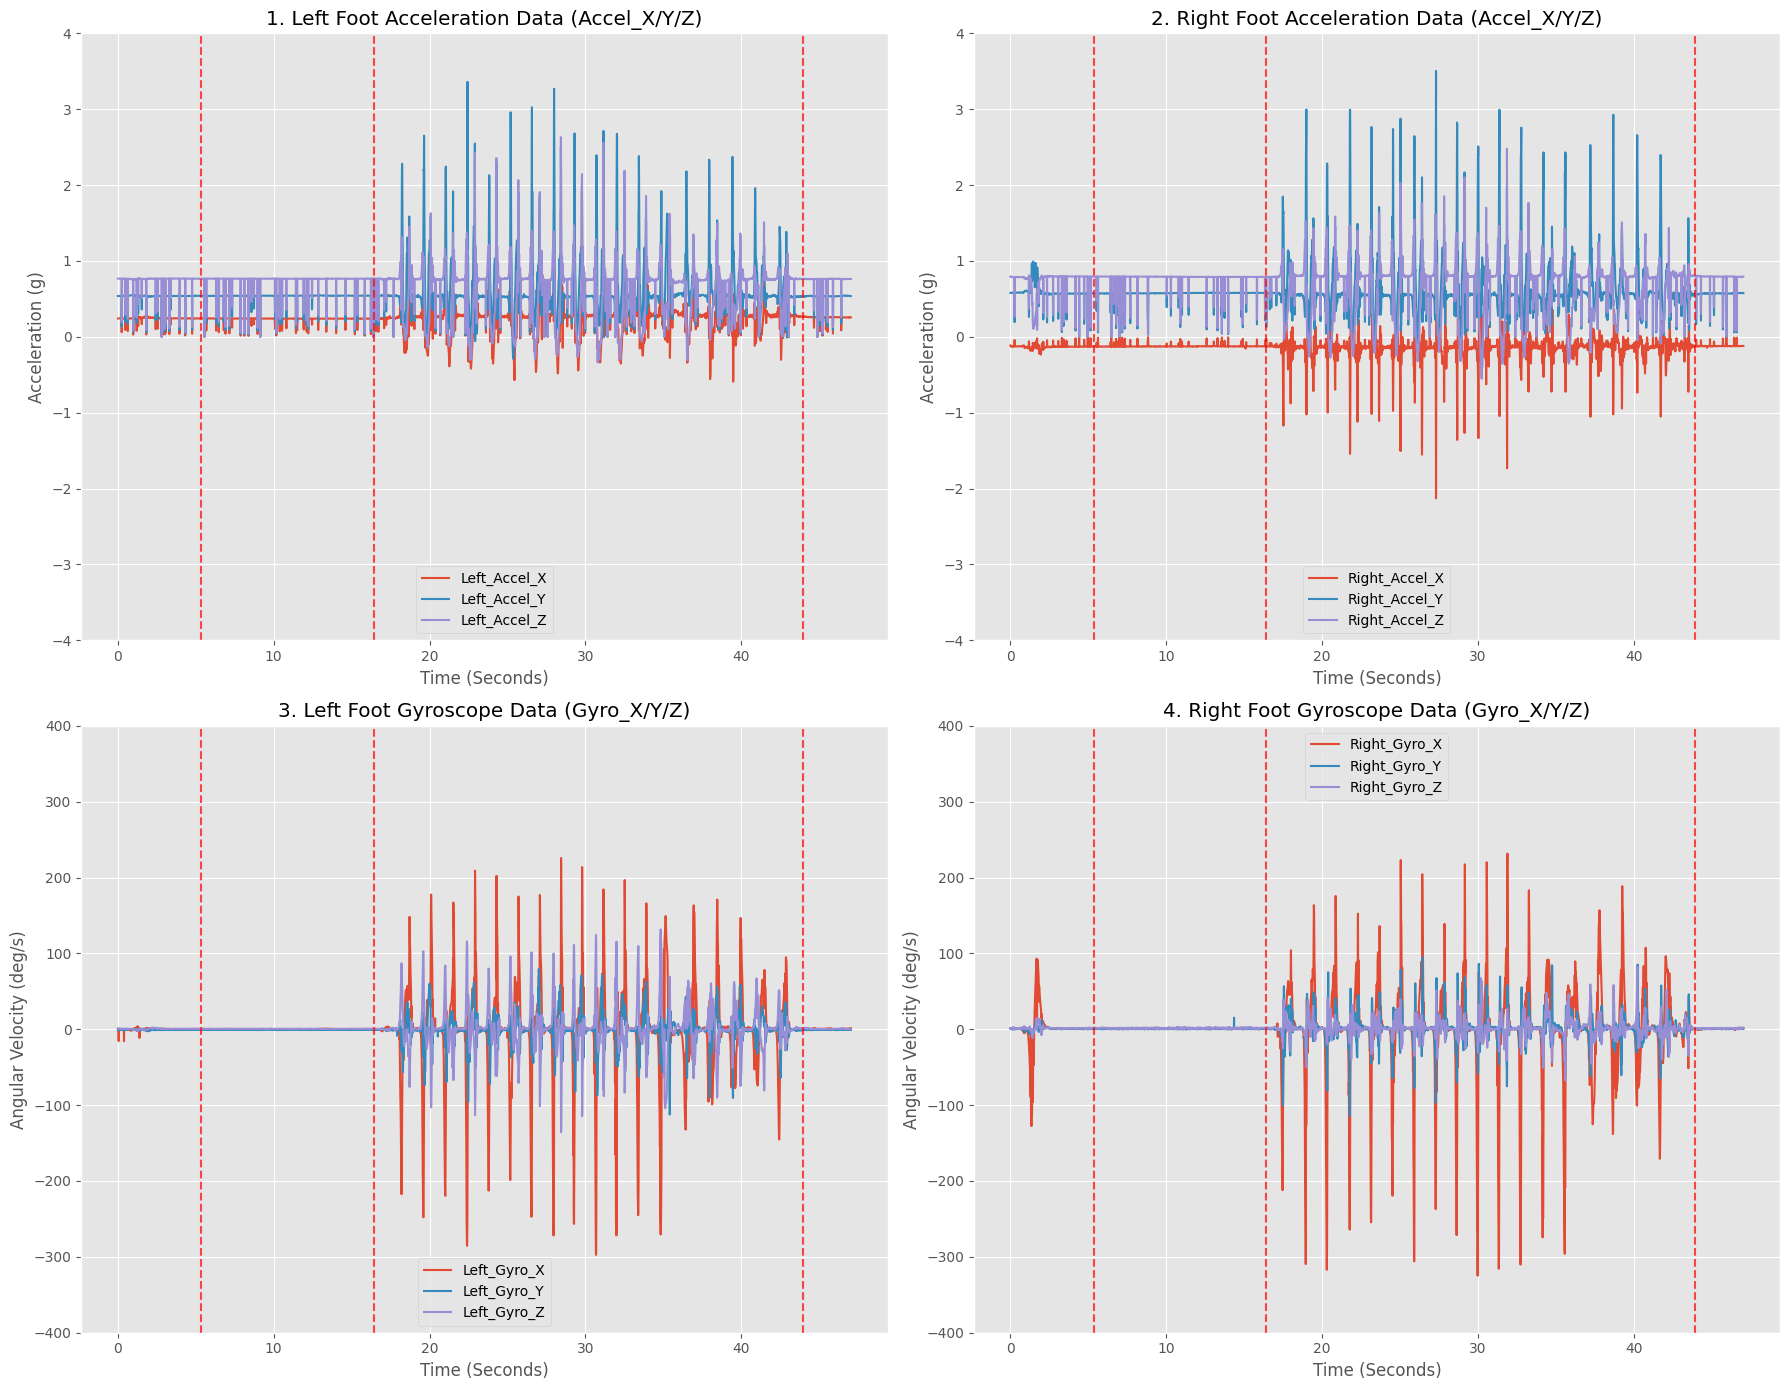

In [350]:
import matplotlib.pyplot as plt

# マーカーが記録されている時刻を取得（NaNでない行）
marker_times = df_interpolated[df_interpolated['Marker_y'].notna()]['Time (Seconds)']
print(f"マーカー数: {len(marker_times)}")

# 軸の列定義
accel_cols = ['Accel_X', 'Accel_Y', 'Accel_Z']
gyro_cols = ['Gyro_X', 'Gyro_Y', 'Gyro_Z']
time_col = 'Time (Seconds)'

# 4つのサブプロットを作成 (2行 x 2列)
fig, axes = plt.subplots(2, 2, figsize=(18, 14)) 
plt.style.use('ggplot')

# =====================================================
# 1. 加速度データ - 左足 (axes[0, 0])
# =====================================================
ax = axes[0, 0]
for col in accel_cols:
    ax.plot(df_interpolated[time_col], df_interpolated[f'Left_{col}'], label=f'Left_{col}')
for t in marker_times:
    ax.axvline(x=t, color='red', linestyle='--', alpha=0.7, linewidth=1.5)
ax.set_title('1. Left Foot Acceleration Data (Accel_X/Y/Z)')
ax.set_xlabel('Time (Seconds)')
ax.set_ylabel('Acceleration (g)')
ax.set_ylim([-4, 4])
ax.legend(loc='best')
ax.grid(True)

# =====================================================
# 2. 加速度データ - 右足 (axes[0, 1])
# =====================================================
ax = axes[0, 1]
for col in accel_cols:
    ax.plot(df_interpolated[time_col], df_interpolated[f'Right_{col}'], label=f'Right_{col}')
for t in marker_times:
    ax.axvline(x=t, color='red', linestyle='--', alpha=0.7, linewidth=1.5)
ax.set_title('2. Right Foot Acceleration Data (Accel_X/Y/Z)')
ax.set_xlabel('Time (Seconds)')
ax.set_ylabel('Acceleration (g)')
ax.set_ylim([-4, 4])
ax.legend(loc='best')
ax.grid(True)

# =====================================================
# 3. 角速度データ - 左足 (axes[1, 0])
# =====================================================
ax = axes[1, 0]
for col in gyro_cols:
    ax.plot(df_interpolated[time_col], df_interpolated[f'Left_{col}'], label=f'Left_{col}')
for t in marker_times:
    ax.axvline(x=t, color='red', linestyle='--', alpha=0.7, linewidth=1.5)
ax.set_title('3. Left Foot Gyroscope Data (Gyro_X/Y/Z)')
ax.set_xlabel('Time (Seconds)')
ax.set_ylabel('Angular Velocity (deg/s)')
ax.set_ylim([-400, 400])
ax.legend(loc='best')
ax.grid(True)

# =====================================================
# 4. 角速度データ - 右足 (axes[1, 1])
# =====================================================
ax = axes[1, 1]
for col in gyro_cols:
    ax.plot(df_interpolated[time_col], df_interpolated[f'Right_{col}'], label=f'Right_{col}')
for t in marker_times:
    ax.axvline(x=t, color='red', linestyle='--', alpha=0.7, linewidth=1.5)
ax.set_title('4. Right Foot Gyroscope Data (Gyro_X/Y/Z)')
ax.set_xlabel('Time (Seconds)')
ax.set_ylabel('Angular Velocity (deg/s)')
ax.set_ylim([-400, 400])
ax.legend(loc='best')
ax.grid(True)

# レイアウトの調整
plt.tight_layout()
plt.show()

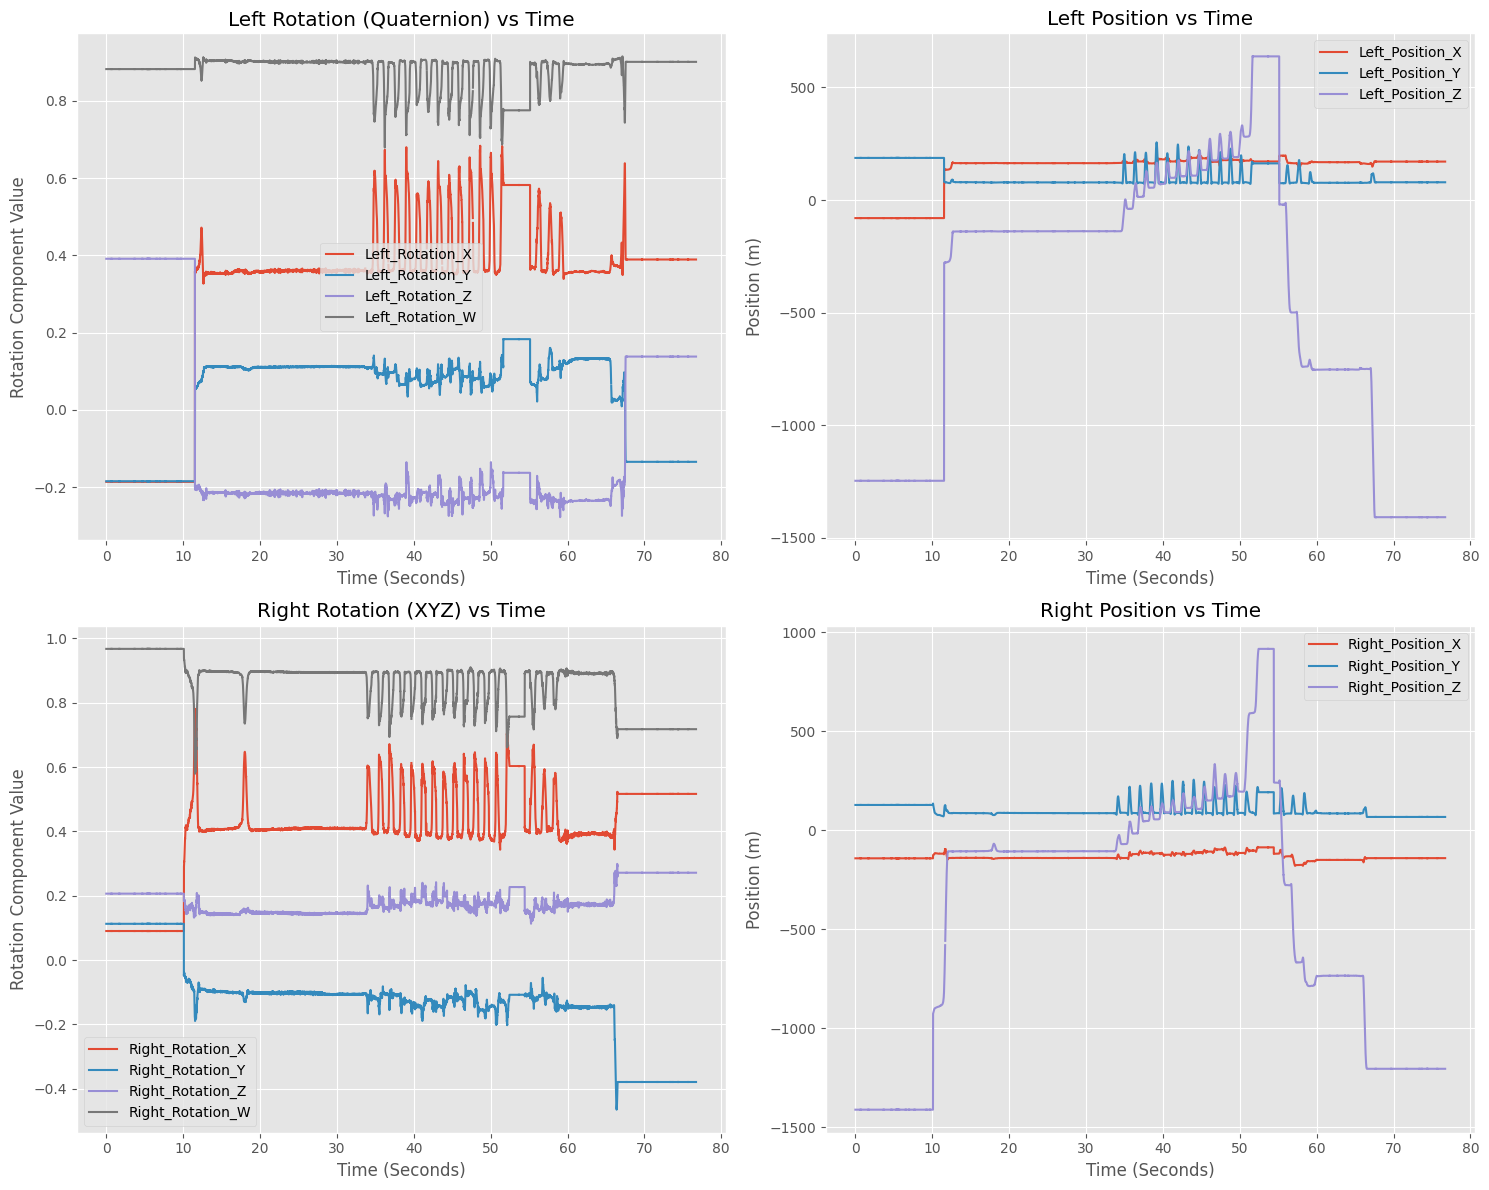

In [351]:
# 2x2のサブプロットを作成し、グリッドスタイルを設定
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
plt.style.use('ggplot')

time_col = 'Time (Seconds)'

# 1. Left Rotation vs Time (左上)
# Left_Rotation_X, Left_Rotation_Y, Left_Rotation_Z, Left_Rotation_W をプロット
rot_cols_left = ['Left_Rotation_X', 'Left_Rotation_Y', 'Left_Rotation_Z', 'Left_Rotation_W']
df_motion_capture.plot(x=time_col, y=rot_cols_left, ax=axes[0, 0])
axes[0, 0].set_title('Left Rotation (Quaternion) vs Time')
axes[0, 0].set_xlabel('Time (Seconds)')
axes[0, 0].set_ylabel('Rotation Component Value')
axes[0, 0].grid(True)
axes[0, 0].legend(loc='best')

# 2. Left Position vs Time (右上)
# Left_Position_X, Left_Position_Y, Left_Position_Z をプロット
pos_cols_left = ['Left_Position_X', 'Left_Position_Y', 'Left_Position_Z']
df_motion_capture.plot(x=time_col, y=pos_cols_left, ax=axes[0, 1])
axes[0, 1].set_title('Left Position vs Time')
axes[0, 1].set_xlabel('Time (Seconds)')
axes[0, 1].set_ylabel('Position (m)')
axes[0, 1].grid(True)
axes[0, 1].legend(loc='best')

# 3. Right Rotation vs Time (左下)
# ご提示の列リストに Right_Rotation_W がないため、X, Y, Z のみをプロット
rot_cols_right = ['Right_Rotation_X', 'Right_Rotation_Y', 'Right_Rotation_Z', 'Right_Rotation_W']
df_motion_capture.plot(x=time_col, y=rot_cols_right, ax=axes[1, 0])
axes[1, 0].set_title('Right Rotation (XYZ) vs Time')
axes[1, 0].set_xlabel('Time (Seconds)')
axes[1, 0].set_ylabel('Rotation Component Value')
axes[1, 0].grid(True)
axes[1, 0].legend(loc='best')

# 4. Right Position vs Time (右下)
# Right_Position_X, Right_Position_Y, Right_Position_Z をプロット
pos_cols_right = ['Right_Position_X', 'Right_Position_Y', 'Right_Position_Z']
df_motion_capture.plot(x=time_col, y=pos_cols_right, ax=axes[1, 1])
axes[1, 1].set_title('Right Position vs Time')
axes[1, 1].set_xlabel('Time (Seconds)')
axes[1, 1].set_ylabel('Position (m)')
axes[1, 1].grid(True)
axes[1, 1].legend(loc='best')

plt.tight_layout() 

In [352]:
import numpy as np
import pandas as pd
from scipy import signal, interpolate

# --- 設定パラメータ ---
MOCAP_FREQ_ORIGINAL = 250  # 元のサンプリング周波数 (Hz)
TARGET_FREQ = 100          # 目標サンプリング周波数 (Hz)
CUTOFF_FREQ = 6            # ローパスフィルタのカットオフ周波数 (Hz) 
FILTER_ORDER = 4           # フィルタの次数

# --- フィルタ関数の定義 (Butterworth Low-pass) ---
def apply_lowpass_filter(data, cutoff, fs, order=4):
    """
    data: 1次元または2次元のnumpy配列
    cutoff: カットオフ周波数 (Hz)
    fs: サンプリング周波数 (Hz)
    order: 次数
    """
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    
    # filtfiltを使って位相ズレのない平滑化を行う (axis=0は行方向=時間方向)
    y = signal.filtfilt(b, a, data, axis=0)
    return y

# ==========================================
# 1. df_motion_capture の処理
# ==========================================

# 平滑化対象のカラムを特定（TimeやError, Frameは除外）
# 回転(Rotation)と位置(Position)を含むカラムを抽出
mocap_cols_to_smooth = [c for c in df_motion_capture.columns if 'Rotation' in c or 'Position' in c]

# 平滑化の実行 (データはコピーして使用)
df_mocap_smooth = df_motion_capture.copy()
# 欠損値の補完
df_mocap_smooth[mocap_cols_to_smooth] = df_mocap_smooth[mocap_cols_to_smooth].interpolate(method='linear', limit_direction='both')
# 平滑化の実行
df_mocap_smooth[mocap_cols_to_smooth] = apply_lowpass_filter(
    df_mocap_smooth[mocap_cols_to_smooth].values, 
    cutoff=CUTOFF_FREQ, 
    fs=MOCAP_FREQ_ORIGINAL, 
    order=FILTER_ORDER
)

# --- ダウンサンプリング処理 (250Hz -> 100Hz) ---
# 時間軸の作成
time_original = df_mocap_smooth['Time (Seconds)'].values
start_time = time_original[0]
end_time = time_original[-1]

# 新しい時間軸を作成 (10ms = 0.01s 間隔)
dt_target = 1 / TARGET_FREQ
new_time_index = np.arange(start_time, end_time, dt_target)

# 新しいDataFrameの準備
df_mocap_resampled = pd.DataFrame({'Time (Seconds)': new_time_index})

# 各カラムを新しい時間軸に合わせて線形補間
# 平滑化済みのデータを使用します
cols_to_resample = mocap_cols_to_smooth  # Errorなどのカラムが必要ならここに追加してください

for col in cols_to_resample:
    # 線形補間関数を作成
    f = interpolate.interp1d(time_original, df_mocap_smooth[col].values, kind='linear', fill_value="extrapolate")
    # 新しい時間軸での値を計算
    df_mocap_resampled[col] = f(new_time_index)

# ==========================================
# 2. df_interpolated の処理
# ==========================================

# 平滑化対象のカラムを特定
# Marker_x, Marker_y, Time (Seconds) 以外をすべて平滑化対象とする
exclude_cols = ['Time (Seconds)', 'Marker_x', 'Marker_y']
interp_cols_to_smooth = [c for c in df_interpolated.columns if c not in exclude_cols]

# 平滑化の実行
df_interpolated_smooth = df_interpolated.copy()
df_interpolated_smooth[interp_cols_to_smooth] = df_interpolated_smooth[interp_cols_to_smooth].interpolate(method='linear', limit_direction='both')
# 100Hzを前提としてフィルタ適用
# ※もしdf_interpolatedの元の周波数が不明であれば、データ点数と時間から計算する必要がありますが、
#   ここでは文脈的に100Hzと仮定しています。
IMU_FREQ = 100 

df_interpolated_smooth[interp_cols_to_smooth] = apply_lowpass_filter(
    df_interpolated_smooth[interp_cols_to_smooth].values, 
    cutoff=CUTOFF_FREQ, 
    fs=IMU_FREQ, 
    order=FILTER_ORDER
)

# 'Marker_x', 'Marker_y' は元の値のまま維持されています

# ==========================================
# 結果の確認
# ==========================================
print("--- Processing Complete ---")
print(f"Original Mocap Shape: {df_motion_capture.shape}")
print(f"Resampled Mocap Shape: {df_mocap_resampled.shape} (Should be approx 2.5x smaller rows)")
print(f"Interpolated (IMU) Shape: {df_interpolated_smooth.shape}")

# 先頭を表示
display(df_mocap_resampled.head())
display(df_interpolated_smooth.head())

--- Processing Complete ---
Original Mocap Shape: (19180, 18)
Resampled Mocap Shape: (7672, 15) (Should be approx 2.5x smaller rows)
Interpolated (IMU) Shape: (4704, 31)


,Time (Seconds),Left_Rotation_X,Left_Rotation_Y,Left_Rotation_Z,Left_Rotation_W,Left_Position_X,Left_Position_Y,Left_Position_Z,Right_Rotation_X,Right_Rotation_Y,Right_Rotation_Z,Right_Rotation_W,Right_Position_X,Right_Position_Y,Right_Position_Z
0,0.00,-0.18647,-0.184944,0.391037,0.882108,-80.274353,187.096405,-1247.434814,0.09044,0.112843,0.206613,0.967677,-142.620331,126.93766,-1412.460205
1,0.01,-0.18647,-0.184944,0.391037,0.882108,-80.274353,187.096405,-1247.434814,0.09044,0.112843,0.206613,0.967677,-142.620331,126.93766,-1412.460205
2,0.02,-0.18647,-0.184944,0.391037,0.882108,-80.274353,187.096405,-1247.434814,0.09044,0.112843,0.206613,0.967677,-142.620331,126.93766,-1412.460205
3,0.03,-0.18647,-0.184944,0.391037,0.882108,-80.274353,187.096405,-1247.434814,0.09044,0.112843,0.206613,0.967677,-142.620331,126.93766,-1412.460205
4,0.04,-0.18647,-0.184944,0.391037,0.882108,-80.274353,187.096405,-1247.434814,0.09044,0.112843,0.206613,0.967677,-142.620331,126.93766,-1412.460205


,Time (Seconds),Marker_x,Marker_y,Left_kPa_1,Left_kPa_2,Left_kPa_3,Left_kPa_4,Left_kPa_5,Left_kPa_6,Left_kPa_7,...,Right_kPa_5,Right_kPa_6,Right_kPa_7,Right_kPa_8,Right_Accel_X,Right_Accel_Y,Right_Accel_Z,Right_Gyro_X,Right_Gyro_Y,Right_Gyro_Z
0,0.00,NaN,NaN,26.394430,22.774721,13.254474,14.728006,68.394981,15.366984,9.059826,...,184.977134,4.576579,4.723260,2.200732,-0.114772,0.578469,0.794991,0.984914,1.493979,1.401170
1,0.01,NaN,NaN,26.550877,22.891678,13.272174,14.768428,67.883462,15.220967,9.199993,...,184.099476,4.509355,4.538520,2.121156,-0.117520,0.578484,0.793001,0.907679,1.256773,1.382841
2,0.02,NaN,NaN,26.712717,22.996841,13.286646,14.808024,67.403767,15.088308,9.323128,...,183.206182,4.466279,4.363687,2.047119,-0.120085,0.578372,0.790959,0.829893,1.031082,1.361298
3,0.03,NaN,NaN,26.886539,23.082791,13.297937,14.846068,66.980191,14.978372,9.413976,...,182.318899,4.463029,4.207724,1.983176,-0.122330,0.578157,0.788988,0.753852,0.825659,1.333963
4,0.04,NaN,NaN,27.077849,23.144705,13.306162,14.881704,66.630487,14.897772,9.461341,...,181.453453,4.511032,4.077393,1.933157,-0.124156,0.577890,0.787225,0.682097,0.647184,1.300162


マーカー数: 3


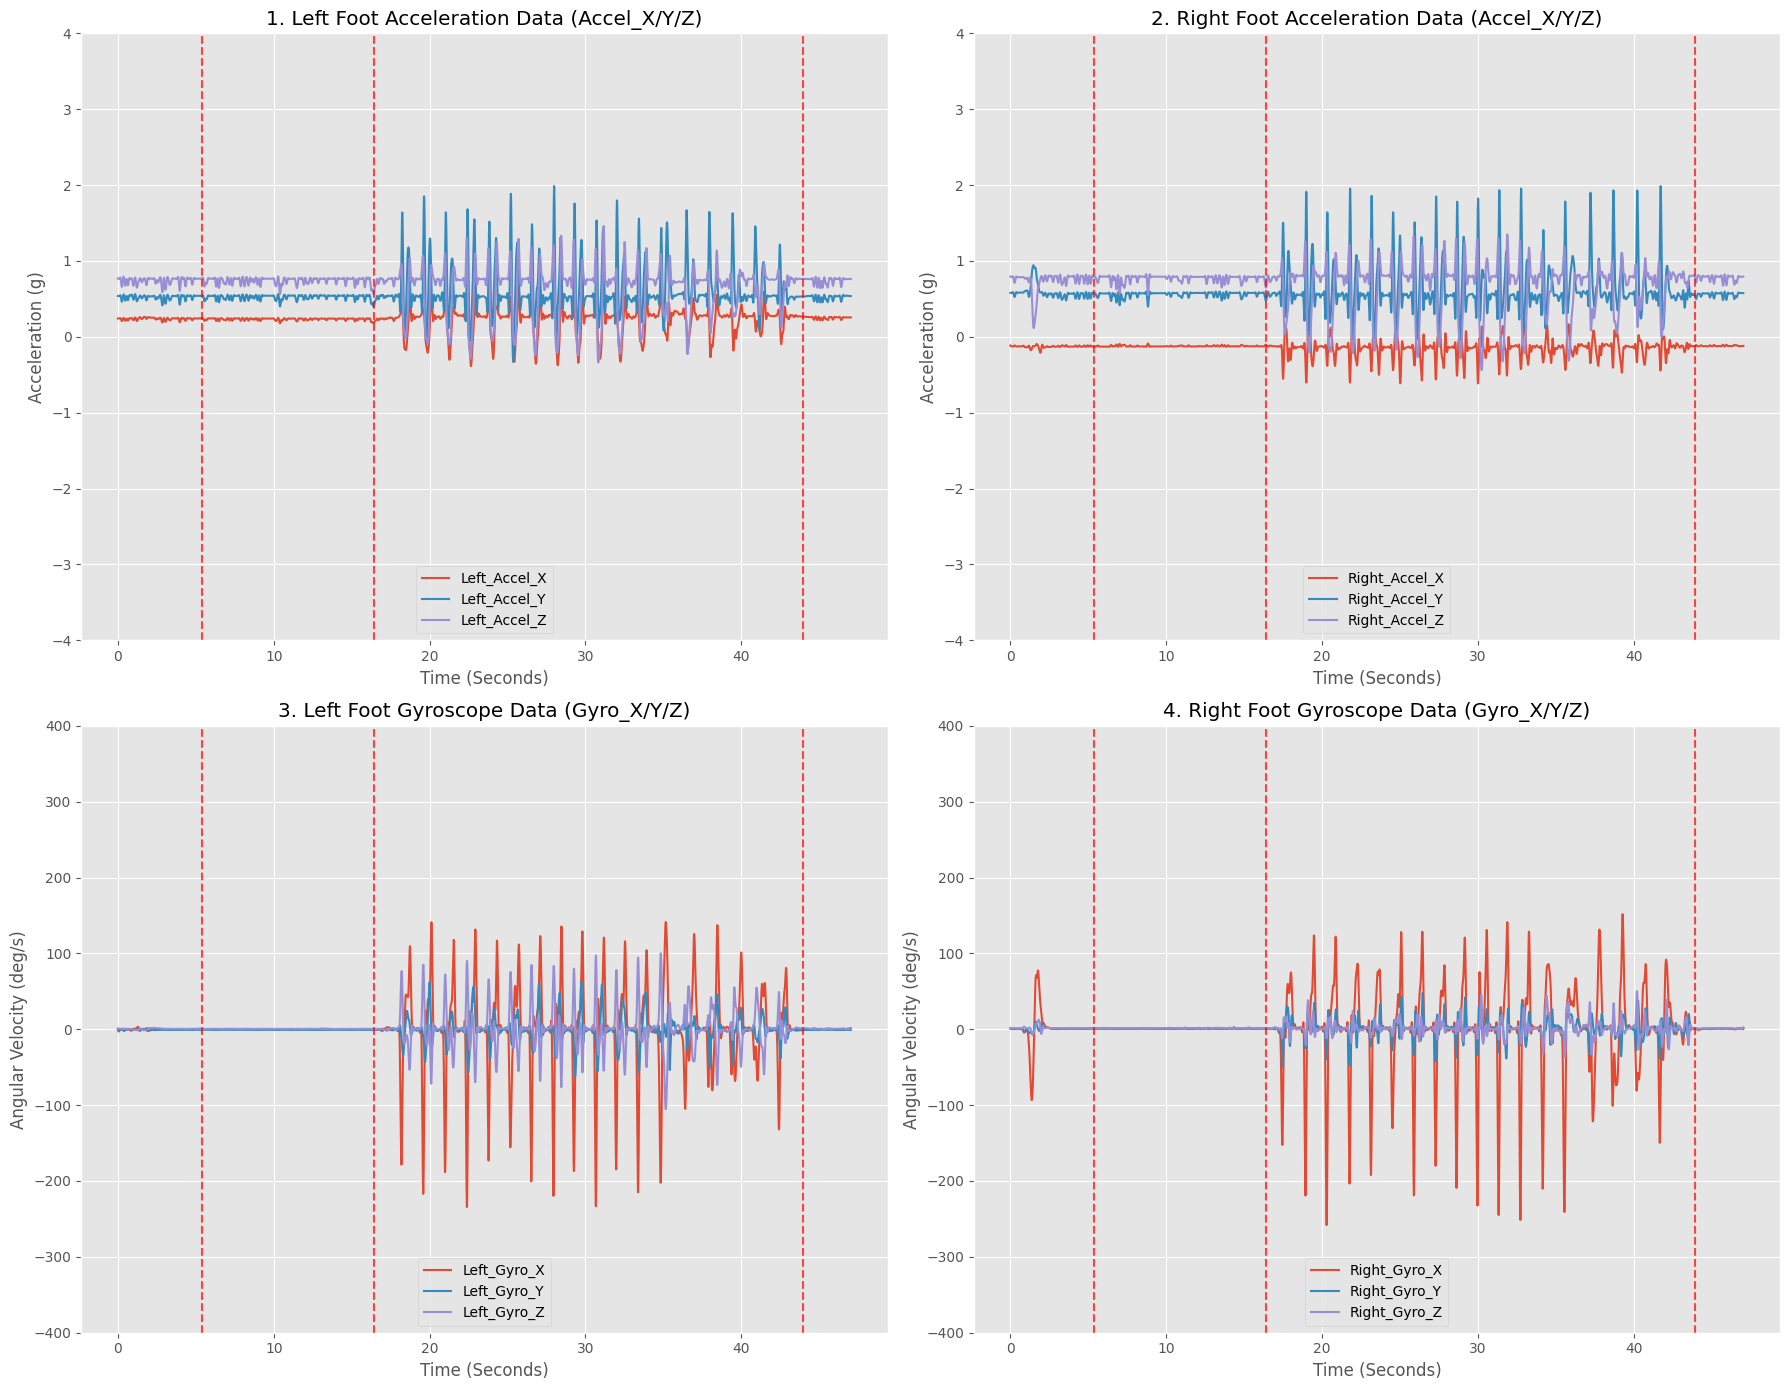

In [353]:
import matplotlib.pyplot as plt

# マーカーが記録されている時刻を取得（NaNでない行）
marker_times = df_interpolated_smooth[df_interpolated_smooth['Marker_y'].notna()]['Time (Seconds)']
print(f"マーカー数: {len(marker_times)}")

# 軸の列定義
accel_cols = ['Accel_X', 'Accel_Y', 'Accel_Z']
gyro_cols = ['Gyro_X', 'Gyro_Y', 'Gyro_Z']
time_col = 'Time (Seconds)'

# 4つのサブプロットを作成 (2行 x 2列)
fig, axes = plt.subplots(2, 2, figsize=(18, 14)) 
plt.style.use('ggplot')

# =====================================================
# 1. 加速度データ - 左足 (axes[0, 0])
# =====================================================
ax = axes[0, 0]
for col in accel_cols:
    ax.plot(df_interpolated_smooth[time_col], df_interpolated_smooth[f'Left_{col}'], label=f'Left_{col}')
for t in marker_times:
    ax.axvline(x=t, color='red', linestyle='--', alpha=0.7, linewidth=1.5)
ax.set_title('1. Left Foot Acceleration Data (Accel_X/Y/Z)')
ax.set_xlabel('Time (Seconds)')
ax.set_ylabel('Acceleration (g)')
ax.set_ylim([-4, 4])
ax.legend(loc='best')
ax.grid(True)

# =====================================================
# 2. 加速度データ - 右足 (axes[0, 1])
# =====================================================
ax = axes[0, 1]
for col in accel_cols:
    ax.plot(df_interpolated_smooth[time_col], df_interpolated_smooth[f'Right_{col}'], label=f'Right_{col}')
for t in marker_times:
    ax.axvline(x=t, color='red', linestyle='--', alpha=0.7, linewidth=1.5)
ax.set_title('2. Right Foot Acceleration Data (Accel_X/Y/Z)')
ax.set_xlabel('Time (Seconds)')
ax.set_ylabel('Acceleration (g)')
ax.set_ylim([-4, 4])
ax.legend(loc='best')
ax.grid(True)

# =====================================================
# 3. 角速度データ - 左足 (axes[1, 0])
# =====================================================
ax = axes[1, 0]
for col in gyro_cols:
    ax.plot(df_interpolated_smooth[time_col], df_interpolated_smooth[f'Left_{col}'], label=f'Left_{col}')
for t in marker_times:
    ax.axvline(x=t, color='red', linestyle='--', alpha=0.7, linewidth=1.5)
ax.set_title('3. Left Foot Gyroscope Data (Gyro_X/Y/Z)')
ax.set_xlabel('Time (Seconds)')
ax.set_ylabel('Angular Velocity (deg/s)')
ax.set_ylim([-400, 400])
ax.legend(loc='best')
ax.grid(True)

# =====================================================
# 4. 角速度データ - 右足 (axes[1, 1])
# =====================================================
ax = axes[1, 1]
for col in gyro_cols:
    ax.plot(df_interpolated_smooth[time_col], df_interpolated_smooth[f'Right_{col}'], label=f'Right_{col}')
for t in marker_times:
    ax.axvline(x=t, color='red', linestyle='--', alpha=0.7, linewidth=1.5)
ax.set_title('4. Right Foot Gyroscope Data (Gyro_X/Y/Z)')
ax.set_xlabel('Time (Seconds)')
ax.set_ylabel('Angular Velocity (deg/s)')
ax.set_ylim([-400, 400])
ax.legend(loc='best')
ax.grid(True)

# レイアウトの調整
plt.tight_layout()
plt.show()

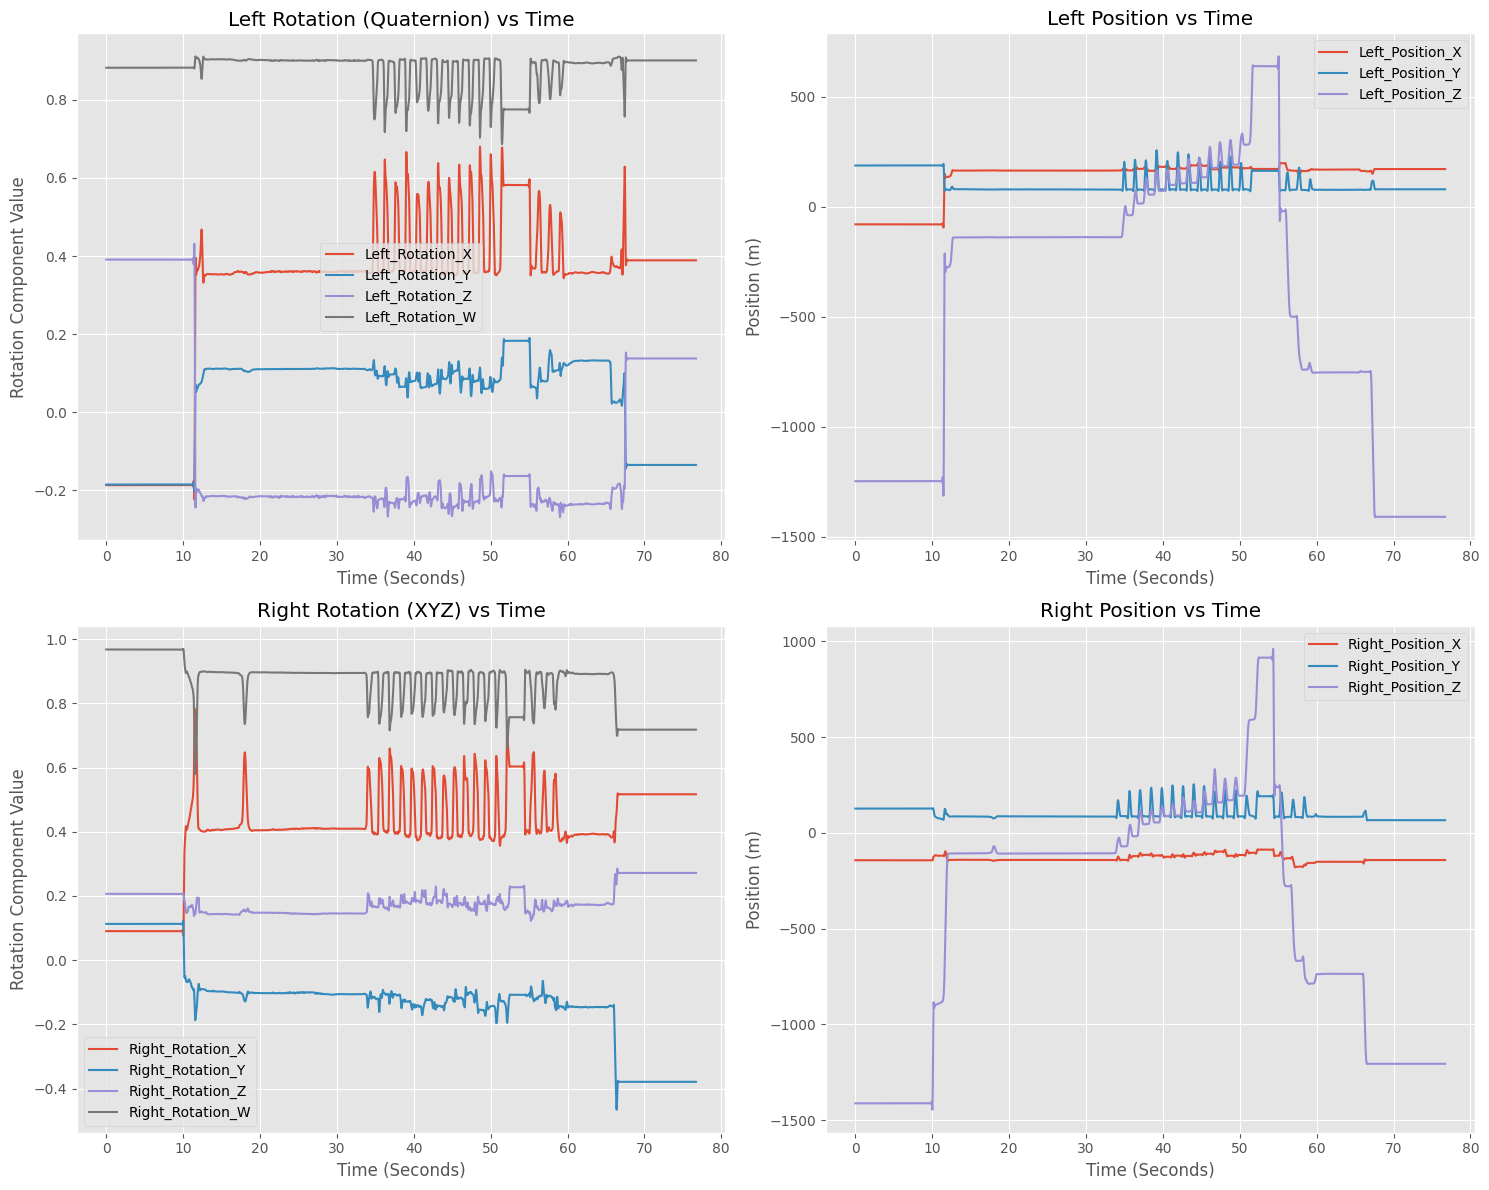

In [354]:
# 2x2のサブプロットを作成し、グリッドスタイルを設定
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
plt.style.use('ggplot')

time_col = 'Time (Seconds)'

# 1. Left Rotation vs Time (左上)
# Left_Rotation_X, Left_Rotation_Y, Left_Rotation_Z, Left_Rotation_W をプロット
rot_cols_left = ['Left_Rotation_X', 'Left_Rotation_Y', 'Left_Rotation_Z', 'Left_Rotation_W']
df_mocap_resampled.plot(x=time_col, y=rot_cols_left, ax=axes[0, 0])
axes[0, 0].set_title('Left Rotation (Quaternion) vs Time')
axes[0, 0].set_xlabel('Time (Seconds)')
axes[0, 0].set_ylabel('Rotation Component Value')
axes[0, 0].grid(True)
axes[0, 0].legend(loc='best')

# 2. Left Position vs Time (右上)
# Left_Position_X, Left_Position_Y, Left_Position_Z をプロット
pos_cols_left = ['Left_Position_X', 'Left_Position_Y', 'Left_Position_Z']
df_mocap_resampled.plot(x=time_col, y=pos_cols_left, ax=axes[0, 1])
axes[0, 1].set_title('Left Position vs Time')
axes[0, 1].set_xlabel('Time (Seconds)')
axes[0, 1].set_ylabel('Position (m)')
axes[0, 1].grid(True)
axes[0, 1].legend(loc='best')

# 3. Right Rotation vs Time (左下)
# ご提示の列リストに Right_Rotation_W がないため、X, Y, Z のみをプロット
rot_cols_right = ['Right_Rotation_X', 'Right_Rotation_Y', 'Right_Rotation_Z', 'Right_Rotation_W']
df_mocap_resampled.plot(x=time_col, y=rot_cols_right, ax=axes[1, 0])
axes[1, 0].set_title('Right Rotation (XYZ) vs Time')
axes[1, 0].set_xlabel('Time (Seconds)')
axes[1, 0].set_ylabel('Rotation Component Value')
axes[1, 0].grid(True)
axes[1, 0].legend(loc='best')

# 4. Right Position vs Time (右下)
# Right_Position_X, Right_Position_Y, Right_Position_Z をプロット
pos_cols_right = ['Right_Position_X', 'Right_Position_Y', 'Right_Position_Z']
df_mocap_resampled.plot(x=time_col, y=pos_cols_right, ax=axes[1, 1])
axes[1, 1].set_title('Right Position vs Time')
axes[1, 1].set_xlabel('Time (Seconds)')
axes[1, 1].set_ylabel('Position (m)')
axes[1, 1].grid(True)
axes[1, 1].legend(loc='best')

plt.tight_layout() 

In [355]:
import numpy as np
import pandas as pd
from scipy.spatial.transform import Rotation as R

# --- パラメータ設定 ---
DT = 1 / 100  # サンプリング周期 (0.01s)
GRAVITY = 9.80665 # 重力加速度 (m/s^2)

# 結果を格納するDataFrameを作成
df_calculated = df_mocap_resampled.copy()

# ==========================================
# 1. 位置 -> 速度 -> 加速度 (G)
# ==========================================
sides = ['Left', 'Right']

for side in sides:
    col_x, col_y, col_z = f'{side}_Position_X', f'{side}_Position_Y', f'{side}_Position_Z'
    
    # 位置データの取得 (mm)
    pos_data = df_calculated[[col_x, col_y, col_z]].values
    
    # 速度 (Velocity) [mm/s]
    vel_data = np.gradient(pos_data, DT, axis=0)
    
    # 加速度 (Acceleration) [mm/s^2] -> [m/s^2] -> [G]
    # 1000で割ってm/s^2にし、さらに9.80665で割ってGにする
    acc_data_mps2 = np.gradient(vel_data, DT, axis=0) / 1000.0
    acc_data_g = acc_data_mps2 / GRAVITY
    
    # 結果を格納 (単位: G)
    df_calculated[f'{side}_Calc_Accel_X'] = acc_data_g[:, 0]
    df_calculated[f'{side}_Calc_Accel_Y'] = acc_data_g[:, 1]
    df_calculated[f'{side}_Calc_Accel_Z'] = acc_data_g[:, 2]

# ==========================================
# 2. クォータニオン -> 角速度 (deg/s)
# ==========================================
def compute_angular_velocity(quats, dt):
    rots = R.from_quat(quats)
    r_current = rots[:-1]
    r_next = rots[1:]
    r_diff = r_current.inv() * r_next
    rot_vecs = r_diff.as_rotvec()
    
    n = len(rots)
    omegas = np.zeros((n, 3))
    omegas[:-1] = rot_vecs / DT
    omegas[-1] = omegas[-2]
    return omegas

for side in sides:
    cols_q = [f'{side}_Rotation_X', f'{side}_Rotation_Y', f'{side}_Rotation_Z', f'{side}_Rotation_W']
    quats = df_calculated[cols_q].values
    quats = quats / np.linalg.norm(quats, axis=1, keepdims=True)
    
    # 角速度算出 [rad/s]
    ang_vel_rad = compute_angular_velocity(quats, DT)
    
    # 単位変換 [rad/s] -> [deg/s]
    ang_vel_deg = ang_vel_rad * (180 / np.pi)
    
    # 結果格納 (単位: deg/s)
    df_calculated[f'{side}_Calc_Gyro_X'] = ang_vel_deg[:, 0]
    df_calculated[f'{side}_Calc_Gyro_Y'] = ang_vel_deg[:, 1]
    df_calculated[f'{side}_Calc_Gyro_Z'] = ang_vel_deg[:, 2]

# 確認
print("Calculated Columns (Units: Accel=[G], Gyro=[deg/s]):")
display(df_calculated[[
    'Left_Calc_Accel_X', 'Left_Calc_Accel_Y', 'Left_Calc_Accel_Z',
    'Left_Calc_Gyro_X',  'Left_Calc_Gyro_Y',  'Left_Calc_Gyro_Z'
]].head())

Calculated Columns (Units: Accel=[G], Gyro=[deg/s]):


,Left_Calc_Accel_X,Left_Calc_Accel_Y,Left_Calc_Accel_Z,Left_Calc_Gyro_X,Left_Calc_Gyro_Y,Left_Calc_Gyro_Z
0,7.825161e-13,-3.811143e-12,1.750518e-11,-2.525838e-10,1.274255e-10,-8.170759e-11
1,7.752706e-13,-5.665996e-12,2.295381e-11,-1.889063e-10,6.560361e-11,6.613569e-11
2,1.557787e-13,-6.752824e-12,2.191045e-11,-1.069698e-10,-2.026793e-11,1.976924e-10
3,-8.549713e-13,-4.477731e-12,1.054948e-11,-3.282850e-11,-1.118304e-10,2.724176e-10
4,-1.492577e-12,-1.340421e-12,2.086710e-12,4.719022e-11,-2.020072e-10,2.882982e-10


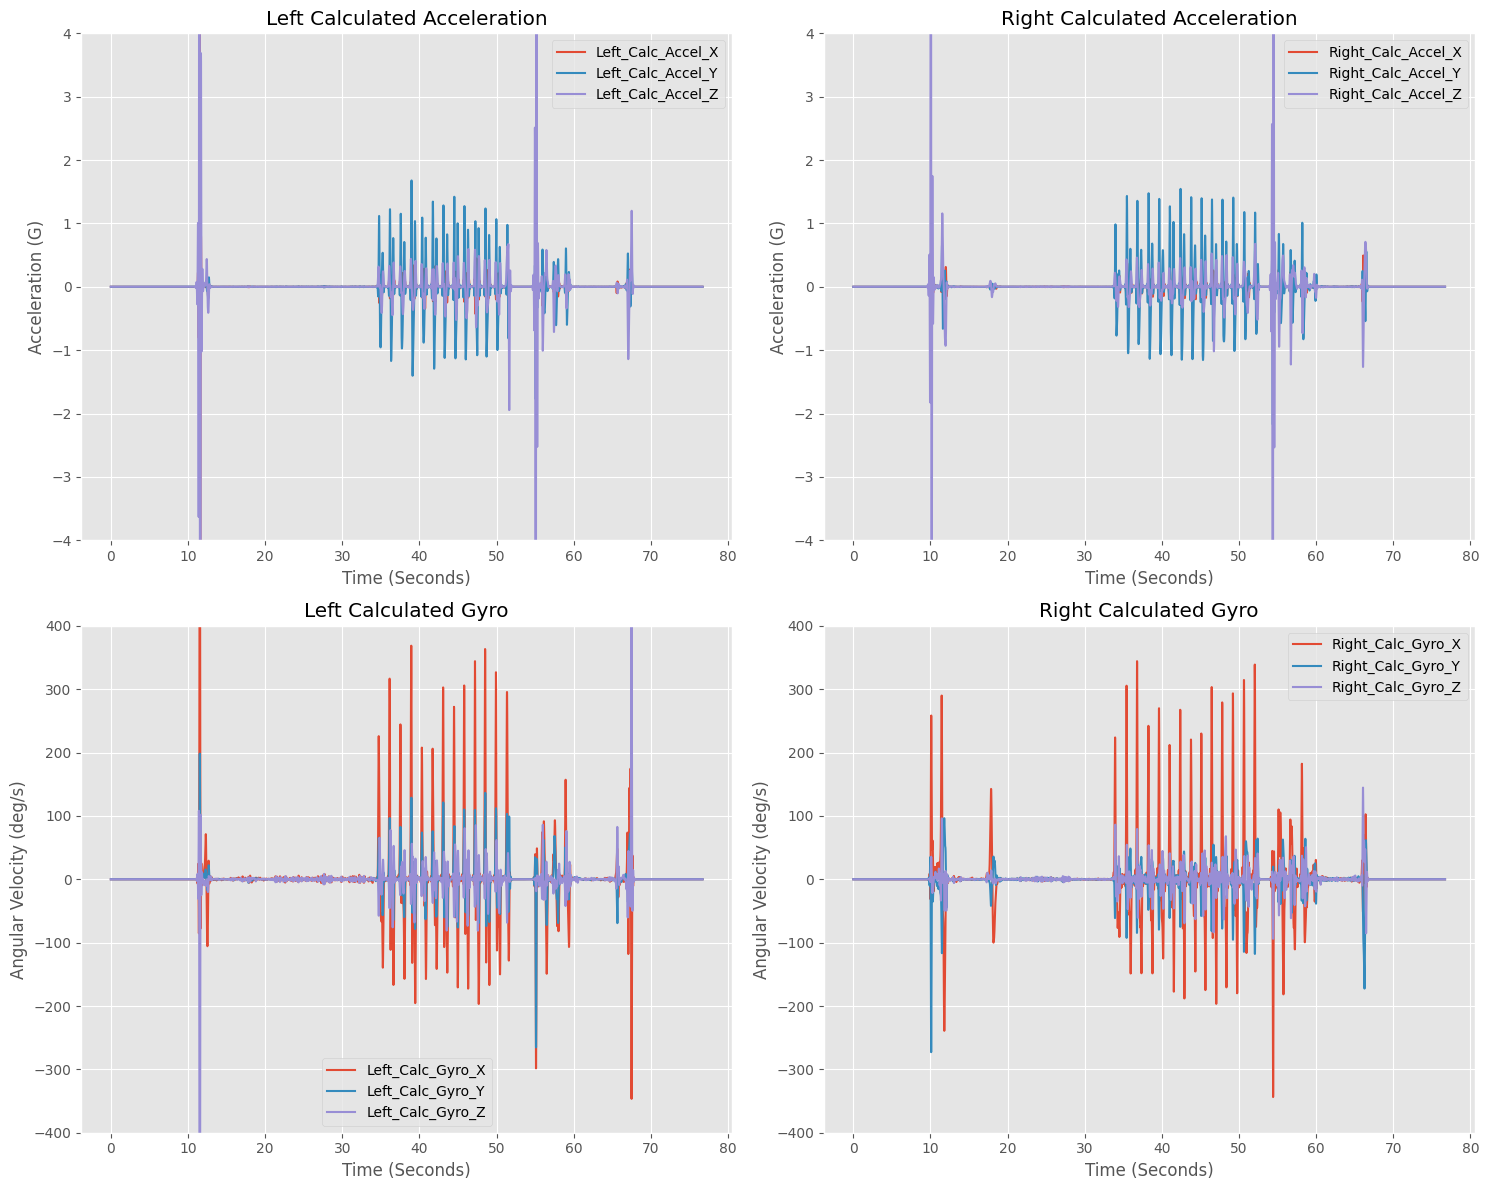

In [356]:
import matplotlib.pyplot as plt

# 2x2のサブプロットを作成
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
plt.style.use('ggplot')

time_col = 'Time (Seconds)'

# --- Left Acceleration (G) ---
acc_cols_left = ['Left_Calc_Accel_X', 'Left_Calc_Accel_Y', 'Left_Calc_Accel_Z']
df_calculated.plot(x=time_col, y=acc_cols_left, ax=axes[0, 0])
axes[0, 0].set_title('Left Calculated Acceleration')
axes[0, 0].set_ylabel('Acceleration (G)')  
axes[0, 0].set_ylim([-4, 4]) 
axes[0, 0].grid(True)

# --- Right Acceleration (G) ---
acc_cols_right = ['Right_Calc_Accel_X', 'Right_Calc_Accel_Y', 'Right_Calc_Accel_Z']
df_calculated.plot(x=time_col, y=acc_cols_right, ax=axes[0, 1])
axes[0, 1].set_title('Right Calculated Acceleration')
axes[0, 1].set_ylabel('Acceleration (G)')  
axes[0, 1].set_ylim([-4, 4]) 
axes[0, 1].grid(True)

# --- Left Gyro (deg/s) ---
gyro_cols_left = ['Left_Calc_Gyro_X', 'Left_Calc_Gyro_Y', 'Left_Calc_Gyro_Z']
df_calculated.plot(x=time_col, y=gyro_cols_left, ax=axes[1, 0])
axes[1, 0].set_title('Left Calculated Gyro')
axes[1, 0].set_ylabel('Angular Velocity (deg/s)') 
axes[1, 0].set_ylim([-400, 400])
axes[1, 0].grid(True)

# --- Right Gyro (deg/s) ---
gyro_cols_right = ['Right_Calc_Gyro_X', 'Right_Calc_Gyro_Y', 'Right_Calc_Gyro_Z']
df_calculated.plot(x=time_col, y=gyro_cols_right, ax=axes[1, 1])
axes[1, 1].set_title('Right Calculated Gyro')
axes[1, 1].set_ylabel('Angular Velocity (deg/s)') 
axes[1, 1].set_ylim([-400, 400])
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

In [357]:
from scipy.spatial.transform import Rotation as R

# 結果を格納するDataFrame (df_calculated を使用)
# 既存の列を消さないようにコピー
df_final = df_calculated.copy()

sides = ['Left', 'Right']

for side in sides:
    # 1. 必要なデータの取得
    # グローバル加速度 (G)
    col_acc_g_x = f'{side}_Calc_Accel_X'
    col_acc_g_y = f'{side}_Calc_Accel_Y'
    col_acc_g_z = f'{side}_Calc_Accel_Z'
    acc_global = df_final[[col_acc_g_x, col_acc_g_y, col_acc_g_z]].values

    # クォータニオン (x, y, z, w)
    col_q_x = f'{side}_Rotation_X'
    col_q_y = f'{side}_Rotation_Y'
    col_q_z = f'{side}_Rotation_Z'
    col_q_w = f'{side}_Rotation_W'
    quats = df_final[[col_q_x, col_q_y, col_q_z, col_q_w]].values
    
    # 正規化 (計算誤差対策)
    quats = quats / np.linalg.norm(quats, axis=1, keepdims=True)

    # 2. 回転処理 (Global -> Local)
    # scipyの Rotation オブジェクト作成
    r = R.from_quat(quats)
    
    # 逆回転を適用 (inv() を使うことで Global -> Local に変換)
    acc_local_mocap = r.inv().apply(acc_global)
    
    # 一旦、変換そのままの値を格納（Mocap定義のローカル座標）
    # まだ軸の入れ替えはしていません
    df_final[f'{side}_Mocap_Local_Raw_X'] = acc_local_mocap[:, 0]
    df_final[f'{side}_Mocap_Local_Raw_Y'] = acc_local_mocap[:, 1]
    df_final[f'{side}_Mocap_Local_Raw_Z'] = acc_local_mocap[:, 2]

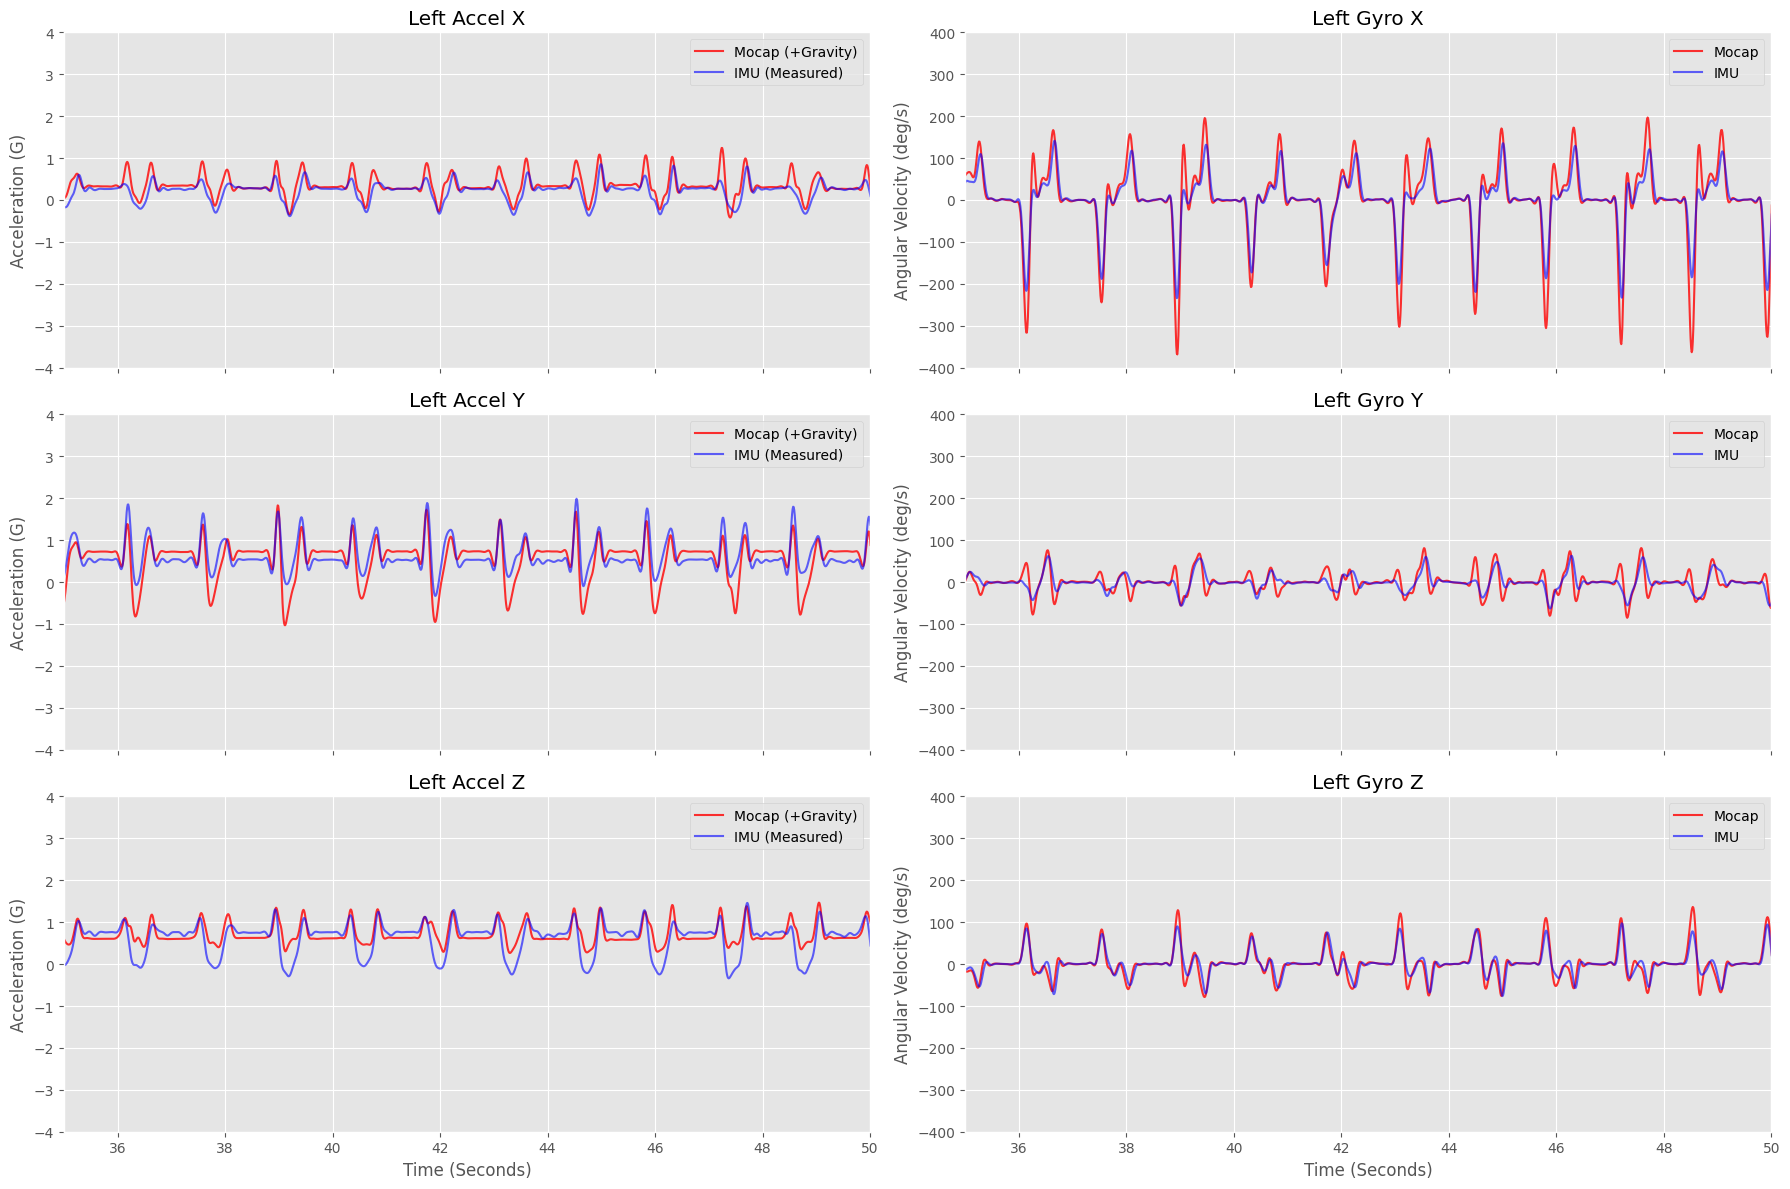

In [366]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

# ==========================================
# 1. 設定セクション (パラメータはここに集約)
# ==========================================
# --- 軸マッピング設定 ---
# Mocapのローカル軸 [0:X, 1:Y, 2:Z] を IMUの [X, Y, Z] にどう割り当てるか
MAPPING_ORDER = [0, 2, 1]  
# 運動成分(加速度・角速度)の符号反転 [X, Y, Z]
MOTION_SIGNS  = [-1, -1, 1] 

# --- 重力成分の合成符号 (今回見つかった法則) ---
# Mocapの運動加速度に対して、重力を「引く(-1)」か「足す(1)」か
# User Result: Xは引く, Yは足す, Zは引く
GRAVITY_MIX_SIGNS = [-1, 1, -1]

# --- グラフ表示設定 ---
MANUAL_OFFSET_SEC = 16.55  # IMUデータの時間シフト量 (秒)
PLOT_SIDE = 'Left'         # 表示する足 ('Left' or 'Right')
PLOT_XLIM = [35, 50]       # 表示する時間範囲 (秒)
PLOT_YLIM_ACC = [-4, 4]    # 加速度のY軸範囲
PLOT_YLIM_GYR = [-400, 400] # 角速度のY軸範囲

# ==========================================
# 2. 計算処理セクション
# ==========================================
# データフレームを初期化 (df_calculatedの内容をコピー)
df_final = df_calculated.copy()

# 重力ベクトルの定義 (Global, Z-down)
gravity_vec_global = np.array([0, 0, -1.0]) 
gravity_global_array = np.tile(gravity_vec_global, (len(df_final), 1))

sides = ['Left', 'Right']

for side in sides:
    # --- A. データの取得 ---
    # グローバル加速度 (Mocap由来)
    acc_global = df_final[[f'{side}_Calc_Accel_X', f'{side}_Calc_Accel_Y', f'{side}_Calc_Accel_Z']].values
    # ローカル角速度 (Mocap由来, マッピング前)
    gyro_raw = df_final[[f'{side}_Calc_Gyro_X', f'{side}_Calc_Gyro_Y', f'{side}_Calc_Gyro_Z']].values
    # クォータニオン
    quats = df_final[[f'{side}_Rotation_X', f'{side}_Rotation_Y', f'{side}_Rotation_Z', f'{side}_Rotation_W']].values
    quats = quats / np.linalg.norm(quats, axis=1, keepdims=True) # 正規化

    # --- B. 座標変換 (Global -> Local) ---
    r = R.from_quat(quats)
    r_inv = r.inv()
    
    # 加速度をローカルへ
    acc_local_raw = r_inv.apply(acc_global)
    # 重力ベクトルをローカルへ
    gravity_local_raw = r_inv.apply(gravity_global_array)

    # --- C. 軸マッピング & 符号調整 ---
    # 運動成分(Accel, Gyro) と 重力成分(Gravity) をそれぞれマッピング
    
    acc_mapped = np.zeros_like(acc_local_raw)
    grav_mapped = np.zeros_like(gravity_local_raw)
    gyro_mapped = np.zeros_like(gyro_raw)

    for i in range(3): # X, Y, Z 軸について
        target_idx = MAPPING_ORDER[i] # 元のどの軸を使うか
        sign = MOTION_SIGNS[i]        # 符号はどうするか
        
        acc_mapped[:, i]  = acc_local_raw[:, target_idx] * sign
        gyro_mapped[:, i] = gyro_raw[:, target_idx] * sign
        grav_mapped[:, i] = gravity_local_raw[:, target_idx] * sign # 重力も一旦同じマッピングを通す

    # --- D. データ格納 ---
    # 1. マッピング済み運動加速度 & 角速度
    axis_names = ['X', 'Y', 'Z']
    for i, axis in enumerate(axis_names):
        df_final[f'{side}_Mocap_Mapped_Accel_{axis}'] = acc_mapped[:, i]
        df_final[f'{side}_Mocap_Mapped_Gyro_{axis}']  = gyro_mapped[:, i]

    # 2. 重力込みの加速度を作成 (User指定の符号で合成)
    # Formula: Accel_Final = Accel_Mapped + (Gravity_Mapped * Mix_Sign)
    for i, axis in enumerate(axis_names):
        mix_sign = GRAVITY_MIX_SIGNS[i]
        col_name = f'{side}_Mocap_Accel_with_G_{axis}'
        df_final[col_name] = acc_mapped[:, i] + (grav_mapped[:, i] * mix_sign)

# ==========================================
# 3. 描画セクション
# ==========================================
fig, axes = plt.subplots(3, 2, figsize=(18, 12), sharex=True)
plt.style.use('ggplot')

# 時間軸の作成 (IMU側をシフト)
time_mocap = df_final['Time (Seconds)']
time_imu = df_interpolated_smooth['Time (Seconds)'] + MANUAL_OFFSET_SEC

axes_list = ['X', 'Y', 'Z']

for i, axis in enumerate(axes_list):
    # --- Left Column: Acceleration ---
    col_acc_mocap = f'{PLOT_SIDE}_Mocap_Accel_with_G_{axis}'
    col_acc_imu   = f'{PLOT_SIDE}_Accel_{axis}'
    
    ax_acc = axes[i, 0]
    ax_acc.plot(time_mocap, df_final[col_acc_mocap], label='Mocap (+Gravity)', color='red', alpha=0.8, linewidth=1.5)
    ax_acc.plot(time_imu, df_interpolated_smooth[col_acc_imu], label='IMU (Measured)', color='blue', alpha=0.6, linewidth=1.5)
    
    ax_acc.set_title(f'{PLOT_SIDE} Accel {axis}')
    ax_acc.set_ylabel('Acceleration (G)')
    ax_acc.set_ylim(PLOT_YLIM_ACC)
    ax_acc.grid(True)
    ax_acc.legend(loc='upper right')

    # --- Right Column: Gyro ---
    col_gyro_mocap = f'{PLOT_SIDE}_Mocap_Mapped_Gyro_{axis}'
    col_gyro_imu   = f'{PLOT_SIDE}_Gyro_{axis}'
    
    ax_gyr = axes[i, 1]
    ax_gyr.plot(time_mocap, df_final[col_gyro_mocap], label='Mocap', color='red', alpha=0.8, linewidth=1.5)
    ax_gyr.plot(time_imu, df_interpolated_smooth[col_gyro_imu], label='IMU', color='blue', alpha=0.6, linewidth=1.5)
    
    ax_gyr.set_title(f'{PLOT_SIDE} Gyro {axis}')
    ax_gyr.set_ylabel('Angular Velocity (deg/s)')
    ax_gyr.set_ylim(PLOT_YLIM_GYR)
    ax_gyr.grid(True)
    ax_gyr.legend(loc='upper right')

# X軸の範囲設定 (sharexなので最後に一括適用)
axes[2, 0].set_xlim(PLOT_XLIM)
axes[2, 0].set_xlabel('Time (Seconds)')
axes[2, 1].set_xlabel('Time (Seconds)')

plt.tight_layout()
plt.show()

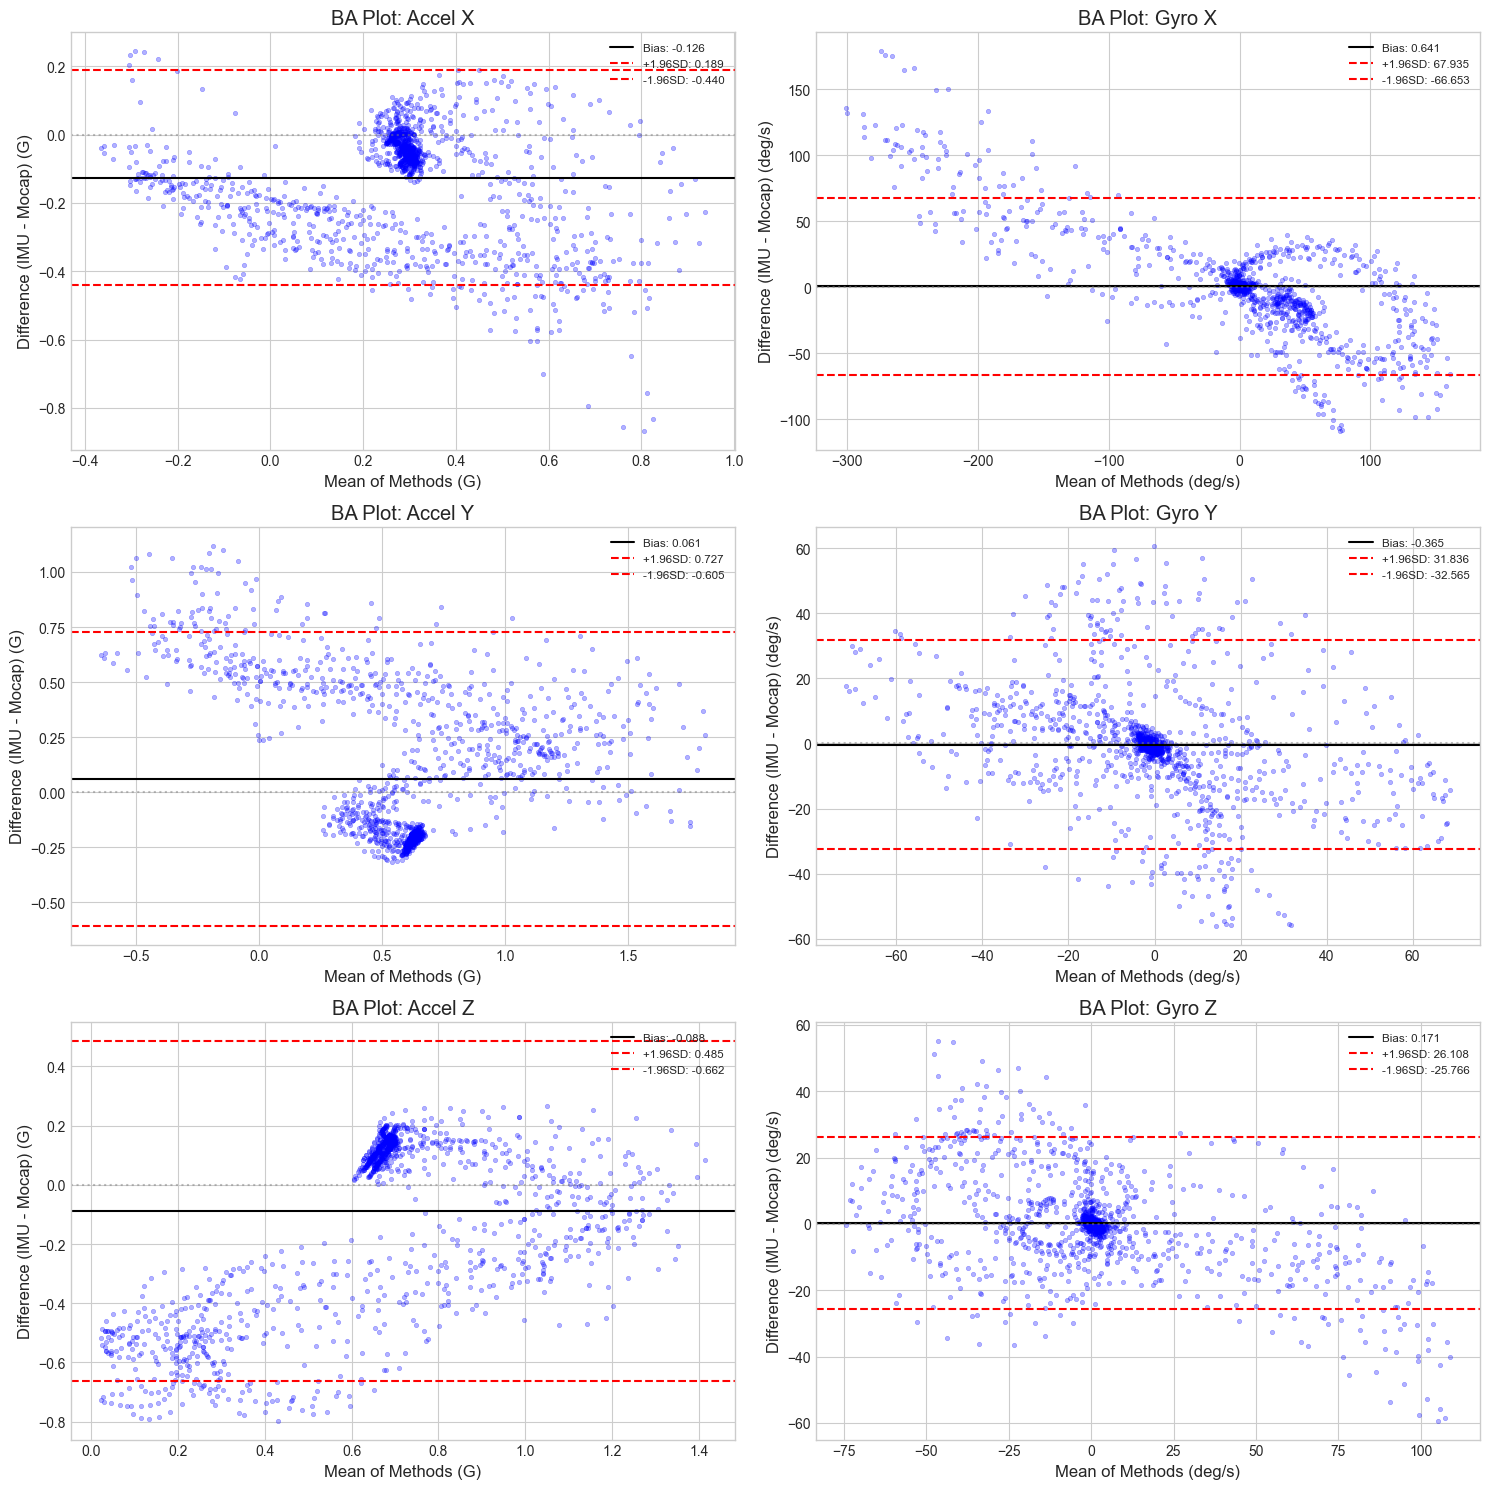


=== Bland-Altman Statistics ===


,Type,Axis,Bias,LoA_Lower,LoA_Upper,SD
0,Accel,X,-0.1256,-0.4405,0.1893,0.1607
1,Gyro,X,0.6407,-66.6533,67.9347,34.3337
2,Accel,Y,0.0608,-0.6052,0.7269,0.3398
3,Gyro,Y,-0.3649,-32.5654,31.8357,16.4288
4,Accel,Z,-0.0885,-0.6615,0.4845,0.2924
5,Gyro,Z,0.1709,-25.7664,26.1083,13.2334


In [370]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate

# ==========================================
# 1. 設定 (先ほどの手動調整値を使用)
# ==========================================
# さきほど決定したパラメータ
MANUAL_OFFSET_SEC = 16.55
SIDE = 'Left'  # 分析する側

# 分析対象の時間を指定 (歩行している区間のみに絞ると精度が上がります)
# 例: [35, 50] のように指定。Noneの場合は全データを使用
ANALYSIS_WINDOW = [35, 50] 

# ==========================================
# 2. データペアリング (同期処理)
# ==========================================
# IMUの時間軸を基準にします
t_imu_raw = df_interpolated_smooth['Time (Seconds)']
t_imu_shifted = t_imu_raw + MANUAL_OFFSET_SEC  # グラフで合わせた時間

# Mocapデータ (df_final) の時間軸
t_mocap = df_final['Time (Seconds)']

# 分析用DataFrameの作成
df_ba = pd.DataFrame({'Time_IMU': t_imu_raw, 'Time_Synced': t_imu_shifted})

# 分析ウィンドウでフィルタリング (必要な場合)
if ANALYSIS_WINDOW:
    mask = (df_ba['Time_Synced'] >= ANALYSIS_WINDOW[0]) & (df_ba['Time_Synced'] <= ANALYSIS_WINDOW[1])
    df_ba = df_ba[mask].copy()
else:
    mask = slice(None)

# Mocapデータを同期時刻に合わせて補間取得する関数
def get_synced_mocap_values(col_name):
    f = interpolate.interp1d(t_mocap, df_final[col_name], kind='linear', fill_value="extrapolate")
    return f(df_ba['Time_Synced'])

# IMUデータを取得する関数 (フィルタリングのみ)
def get_imu_values(col_name):
    return df_interpolated_smooth.loc[mask, col_name].values

# ==========================================
# 3. Bland-Altman プロット関数
# ==========================================
def plot_bland_altman(ax, data1, data2, title, unit):
    # データ1: Mocap (基準), データ2: IMU
    mean = np.mean([data1, data2], axis=0)
    diff = data2 - data1  # IMU - Mocap (差分)
    
    # 統計量
    md = np.mean(diff)            # Mean Difference (Bias)
    sd = np.std(diff, axis=0)     # Standard Deviation
    loa_upper = md + 1.96 * sd    # Upper Limit of Agreement
    loa_lower = md - 1.96 * sd    # Lower Limit of Agreement
    
    # プロット
    ax.scatter(mean, diff, alpha=0.3, s=10, color='blue')
    
    # 基準線
    ax.axhline(md, color='black', linestyle='-', linewidth=1.5, label=f'Bias: {md:.3f}')
    ax.axhline(loa_upper, color='red', linestyle='--', linewidth=1.5, label=f'+1.96SD: {loa_upper:.3f}')
    ax.axhline(loa_lower, color='red', linestyle='--', linewidth=1.5, label=f'-1.96SD: {loa_lower:.3f}')
    ax.axhline(0, color='gray', linestyle=':', alpha=0.5) # ゼロライン
    
    # 装飾
    ax.set_title(title)
    ax.set_xlabel(f'Mean of Methods ({unit})')
    ax.set_ylabel(f'Difference (IMU - Mocap) ({unit})')
    ax.legend(loc='upper right', fontsize='small')
    ax.grid(True)
    
    # 結果を辞書で返す
    return {'Bias': md, 'SD': sd, 'LoA_Upper': loa_upper, 'LoA_Lower': loa_lower}

# ==========================================
# 4. 実行と描画
# ==========================================
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
plt.style.use('seaborn-v0_8-whitegrid')

axes_list = ['X', 'Y', 'Z']
stats_results = []

for i, axis in enumerate(axes_list):
    # --- Acceleration Analysis ---
    # カラム名の構築
    col_mocap_acc = f'{SIDE}_Mocap_Accel_with_G_{axis}' # 重力込みMocap
    col_imu_acc = f'{SIDE}_Accel_{axis}'                # Raw IMU
    
    # データ取得
    d_mocap_acc = get_synced_mocap_values(col_mocap_acc)
    d_imu_acc = get_imu_values(col_imu_acc)
    
    # プロット (左列)
    res_acc = plot_bland_altman(axes[i, 0], d_mocap_acc, d_imu_acc, f'BA Plot: Accel {axis}', 'G')
    res_acc['Type'] = 'Accel'
    res_acc['Axis'] = axis
    stats_results.append(res_acc)
    
    # --- Gyro Analysis ---
    # カラム名の構築
    col_mocap_gyro = f'{SIDE}_Mocap_Mapped_Gyro_{axis}' # マッピング済みMocap
    col_imu_gyro = f'{SIDE}_Gyro_{axis}'                # Raw IMU
    
    # データ取得
    d_mocap_gyro = get_synced_mocap_values(col_mocap_gyro)
    d_imu_gyro = get_imu_values(col_imu_gyro)
    
    # プロット (右列)
    res_gyro = plot_bland_altman(axes[i, 1], d_mocap_gyro, d_imu_gyro, f'BA Plot: Gyro {axis}', 'deg/s')
    res_gyro['Type'] = 'Gyro'
    res_gyro['Axis'] = axis
    stats_results.append(res_gyro)

plt.tight_layout()
plt.show()

# --- 統計結果の表示 ---
df_stats = pd.DataFrame(stats_results)
cols = ['Type', 'Axis', 'Bias', 'LoA_Lower', 'LoA_Upper', 'SD']
print("\n=== Bland-Altman Statistics ===")
display(df_stats[cols].round(4))